### Notebook for testing model
Setup: follow instructions on [author's github](https://github.com/Beckschen/TransUNet)

In [1]:
from PIL import Image, ImageOps 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
import json

# Update max pixel to get rid of DecompressionBombError when reading img
Image.MAX_IMAGE_PIXELS = 933120000

# Test image
TEST_IMAGE_PATH = './images/2ec3f1bb9.tiff'
TEST_LABEL_PATH = './images/2ec3f1bb9-anatomical-structure.json'

# Import image and convert to grayscale
kidney_im = Image.open(TEST_IMAGE_PATH)
kidney_gray_im = ImageOps.grayscale(kidney_im) 

C:\Users\iraha\anaconda3\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (1144874770 pixels) exceeds limit of 933120000 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [2]:
# Convert to numpy array
kidney_array = np.asarray(kidney_gray_im, dtype=np.float32)

### Plot test sample

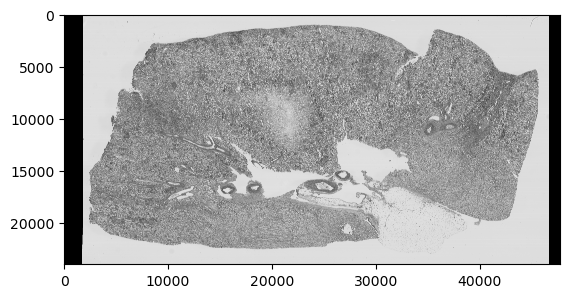

In [3]:
# Plot kidney image
imgplot = plt.imshow(kidney_array, cmap='gray')

### Plotting test sample + Mask

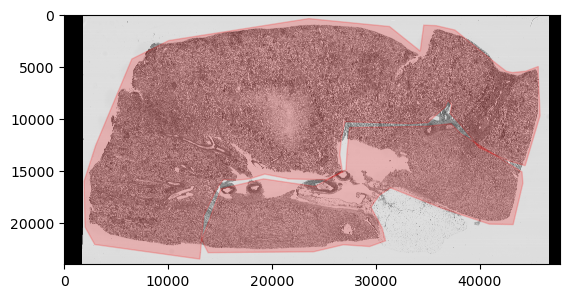

In [4]:
# Load label path from json file
kidney_label = json.load(open(TEST_LABEL_PATH))
for element in kidney_label:
    if element['type'] == 'Feature' and element['id'] == 'PathAnnotationObject':
        label = element['geometry']
        if label['type'] == 'Polygon':
            coordinates = label['coordinates'][0]
            
            # Create polygon from label coordinates and plot
            label_polygon = Polygon(coordinates, closed=True, color='red', alpha=0.2)
            ax = plt.gca()
            ax.add_patch(label_polygon)
            
imgplot = plt.imshow(kidney_array, cmap='gray')

### Test running the model with pretrained weights from the paper's author

In [5]:
# For reloading imports when editing .py files
%load_ext autoreload
%autoreload 2

# Change to networks.linux.vit_seg_modeling if running in linux env
from networks.windows.vit_seg_modeling import VisionTransformer as ViT_seg
from networks.windows.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
import torch

# Func for gettting models with different configs for quickly testing
def run_vit_model(model_name, model_path, n_classes, n_skip, patches_size, img_size, image):
    
    # Apply config for selected network
    config_vit = CONFIGS_ViT_seg[model_name]
    config_vit.n_classes = n_classes
    config_vit.n_skip = n_skip
    config_vit.patches.size = (patches_size, patches_size)
    if model_name.find('R50') !=-1:
            config_vit.patches.grid = (int(img_size/patches_size), int(img_size/patches_size))

    config_vit.pretrained_path = model_path
    net = ViT_seg(config_vit, img_size=img_size, num_classes=n_classes).cuda()

    # Load pretrained weights
    weights = np.load(model_path)
    net.load_from(weights=weights)

    # Run and convert output back to numpy array
    output = net.forward(image)
    output_array = output[0][0].cpu().detach().numpy()
    
    return output_array

### Section out a small block to try running it on the model

In [6]:
# Set where to take sample section from + section size
IMG_SIZE = 1024
X_SEEK = 15000
Y_SEEK = 15000

# Section out a sample image and format for inputting to model
test_block = torch.from_numpy(np.array([np.array([kidney_array[Y_SEEK:Y_SEEK+IMG_SIZE,X_SEEK:X_SEEK+IMG_SIZE]])]))
test_block = test_block.to(torch.device('cuda'))
test_block = test_block.type(torch.cuda.FloatTensor)

### List of available networks with pretrained from the paper
Example on github uses R50-ViT-B_16, get pretrained model files from [this link](https://console.cloud.google.com/storage/browser/vit_models/imagenet21k?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false)

In [7]:
# Available networks
vit_networks = [
    'ViT-B_16',
    'ViT-B_32',
    'ViT-L_16',
    'ViT-L_32',
    'ViT-H_14',
    'R50-ViT-B_16',
    'R50-ViT-L_16',
    'testing'
]

load_pretrained: grid-size from 14 to 64


Text(0.5, 1.0, 'Actual Image (Gray Scale)')

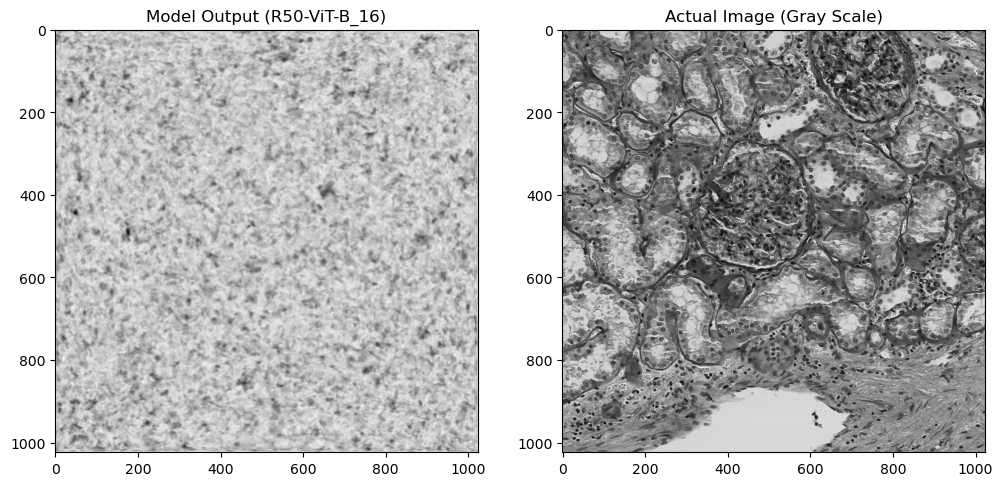

In [8]:
# Set which network to use + set pretrained weight path
VIT_MODEL = 'R50-ViT-B_16'
MODEL_PATH = './models/imagenet21k_R50+ViT-B_16.npz'

output = run_vit_model(
    model_name = VIT_MODEL,
    model_path = MODEL_PATH,
    n_classes = 1,
    n_skip = 1,
    patches_size = 16,
    img_size = IMG_SIZE,
    image = test_block
)

# Plot model output vs actual image
f, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(output, cmap='gray')
axes[0].set_title(f'Model Output ({VIT_MODEL})')
axes[1].imshow(kidney_array[Y_SEEK:Y_SEEK+IMG_SIZE,X_SEEK:X_SEEK+IMG_SIZE], cmap='gray')
axes[1].set_title('Actual Image (Gray Scale)')

### Test running with data used in the paper
The Synapse dataset is found here: [Author's Google Drive Link](https://drive.google.com/drive/folders/1ACJEoTp-uqfFJ73qS3eUObQh52nGuzCd).

To run, extract `Synapse` folder and put it root dir of this repo.

load_pretrained: grid-size from 14 to 32


Text(0.5, 1.0, 'Actual Image (Gray Scale)')

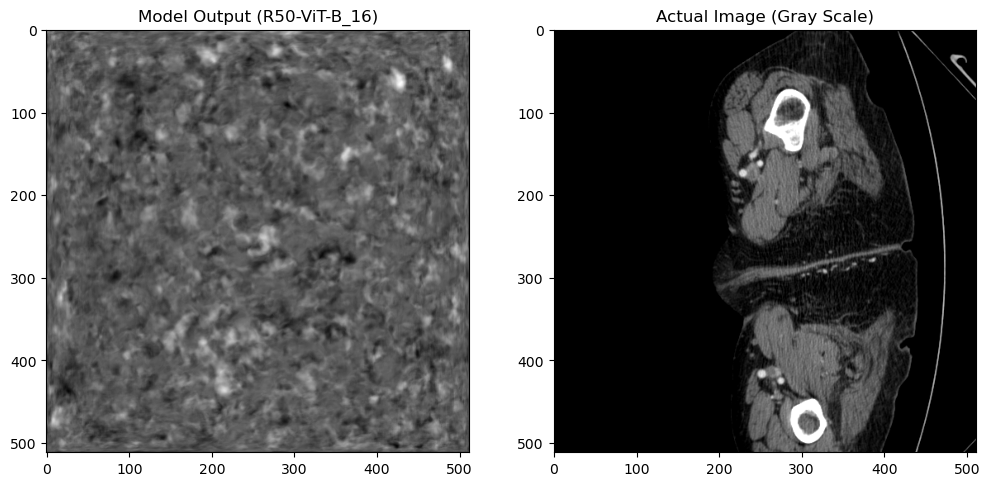

In [22]:
import h5py

# Import Synapse file
h5 = h5py.File('./Synapse/test_vol_h5/case0001.npy.h5','r')

# Convert to tensor
img_tensor = torch.from_numpy(np.asarray([[h5['image'][0]]]))
img_tensor = img_tensor.to(torch.device('cuda'))
img_tensor = img_tensor.type(torch.cuda.FloatTensor)

output = run_vit_model(
    model_name = VIT_MODEL,
    model_path = MODEL_PATH,
    n_classes = 1,
    n_skip = 1,
    patches_size = 16,
    img_size = 512,
    image = img_tensor
)

# Plot model output vs actual image
f, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(output, cmap='gray')
axes[0].set_title(f'Model Output ({VIT_MODEL})')
axes[1].imshow(h5['image'][0], cmap='gray')
axes[1].set_title('Actual Image (Gray Scale)')